In [1]:
import obspy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
from obspy import read

In [8]:
# in_path = "/eos/user/l/2019/"
in_path = "/home/llayer/Data/ascii_30/2019/"

In [9]:
import glob
ascii_files = glob.glob(in_path + "*/*/*.ascii")

In [11]:
def filter_sample(file, plot=True):
    
    st = read(file)
    tr = st[0]
    tr = tr.detrend() # TODO: Check if necessary
    # Filtering with a lowpass on a copy of the original Trace
    tr_filt = tr.copy()
    tr_filt.filter( 'bandpass', freqmin = 0.05, freqmax = 0.5, corners=2, zerophase=True)
    
    tr_new = tr_filt.copy()
    tr_new.decimate(factor=6, strict_length=False, no_filter=True)
    
    if plot == True:
        # Now let's plot the raw and filtered data...
        
        t = np.arange(0, tr.stats.npts / tr.stats.sampling_rate, tr.stats.delta)
        t_new = np.arange(0, tr_new.stats.npts / tr_new.stats.sampling_rate,
              tr_new.stats.delta)
        fig = plt.figure(figsize=(10,8), dpi=80)
        plt.subplot(311)
        plt.plot(t, tr.data, 'k', label = 'Raw Data')
        y_font_size = 20
        plt.ylabel('Counts', fontsize=y_font_size)
        plt.legend(loc='lower right', prop={'size': 20})
        plt.subplot(312)
        plt.plot(t, tr_filt.data, 'k', label = 'Bandpassed Data')
        plt.ylabel('Counts', fontsize=y_font_size)
        plt.legend(loc='lower right', prop={'size': 20})
        plt.subplot(313)
        plt.plot(t_new, tr_new.data, 'k', label = 'Downsampled Data')
        plt.ylabel('Counts', fontsize=y_font_size)
        plt.xlabel('Time [s]', fontsize=y_font_size)
        plt.legend(loc='lower right', prop={'size': 20})        
        plt.show()
        
    return tr.data #{'time': tr.stats.starttime, 'waveform': tr_new.data}

In [43]:
test_file = in_path + "05/15/165235_165305_STRA_EHE.ascii"

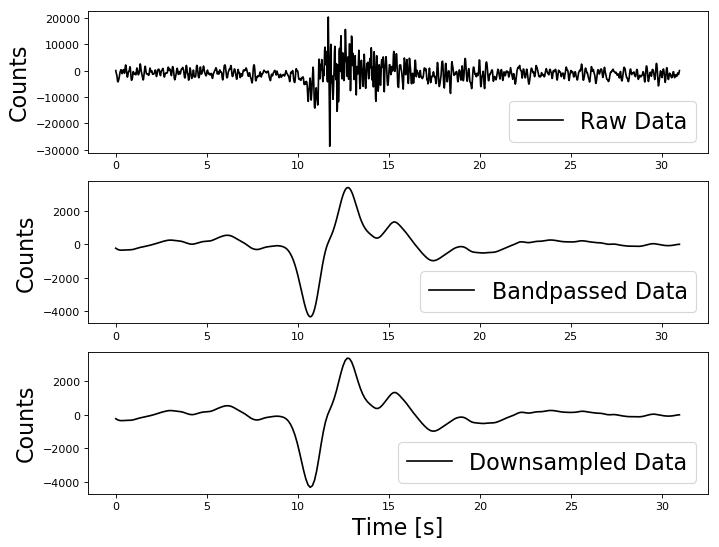

In [15]:
test = filter_sample(test_file, plot = True)

In [16]:
def lpc(file, window = 256, overlap = 128, order=6):

    st = read(file)
    tr = st[0]
    
    if len(tr.data) < 1:
        return None
    
    tr = tr.detrend() # TODO: Check if necessary
    
    data = tr.data
    
    startindex = 0
    endindex = window

    features = []
    
    while endindex <= len(data):
                
        y = data[startindex : endindex]
        lpc = librosa.lpc(y, order)
        features.append( lpc )
        
        startindex = endindex - overlap
        endindex = startindex + window
        
    return features

In [24]:
lpc_coeff = lpc(test_file)
lpc_coeff_flat = np.concatenate(lpc_coeff).ravel()

In [26]:
lpc_coeff

[array([ 1.        , -2.16687222,  2.29387381, -1.61114638,  0.91482865,
        -0.3740787 ,  0.05751241]),
 array([ 1.        , -2.21118105,  2.38931883, -1.67498884,  0.83330445,
        -0.20256299, -0.03618077]),
 array([ 1.        , -2.24495762,  2.39115292, -1.72663783,  0.90531986,
        -0.27545908,  0.00325259]),
 array([ 1.        , -1.55941767,  1.63484296, -1.41006273,  0.89239195,
        -0.41686454,  0.03889347]),
 array([ 1.        , -1.57539002,  1.69421971, -1.41203034,  0.90042097,
        -0.43331286,  0.05687425]),
 array([ 1.        , -1.74368046,  1.94792735, -1.52830528,  1.01505677,
        -0.51897239,  0.13925885]),
 array([ 1.        , -2.20381934,  2.48309912, -1.98249677,  1.42664452,
        -0.79912551,  0.21115937]),
 array([ 1.        , -2.20010615,  2.23355039, -1.41633433,  0.79560054,
        -0.41238533,  0.08242306]),
 array([ 1.        , -1.99665916,  1.79442999, -1.11217709,  0.69785399,
        -0.41111587,  0.09811052]),
 array([ 1.        

Text(0.5, 0, 'Order')

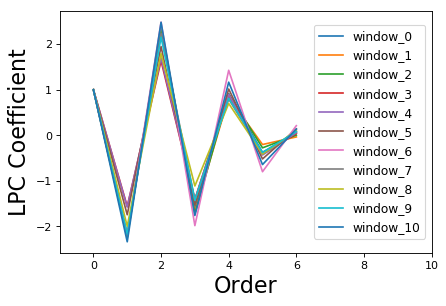

In [42]:
plt.figure(figsize=(6,4), dpi=80)
y_font_size = 20
for i in range(len(lpc_coeff)):
    plt.plot(lpc_coeff[i], label = 'window_' + str(i))
plt.xlim(-1,10)
plt.legend(loc = 'right', prop={'size': 11})
plt.ylabel('LPC Coefficient', fontsize=y_font_size)
plt.xlabel('Order', fontsize=y_font_size)

In [45]:
st = read(test_file)
tr = st[0]
tr = tr.detrend() # TODO: Check if necessary
data = tr.data

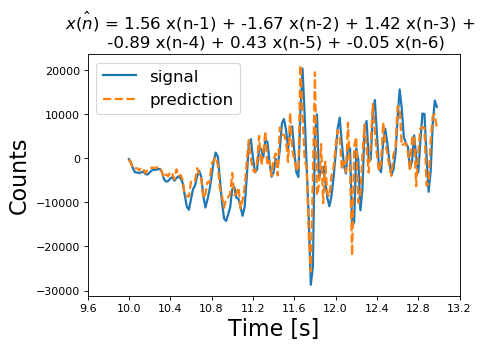

In [154]:
import scipy

sps = 50
start = 10
stop = 13
data_window = data[sps*start:sps*stop]

a = librosa.lpc(data_window, 6)
y_hat = scipy.signal.lfilter([0] + -1*a[1:], [1], data_window)
plt.figure(figsize=(6,4), dpi=80)
y_font_size = 20
plt.plot(data_window, linewidth=2)
plt.plot(y_hat, linestyle='--', linewidth=2)
plt.legend(['signal', 'prediction'], fontsize=15)
plt.ylabel('Counts', fontsize=y_font_size)
plt.xlabel('Time [s]', fontsize=y_font_size)
locs, labels = plt.xticks()
secs = [str(l/50 + start) for l in locs ]
plt.xticks(locs, secs)
formula = r'$\hat{x}(n)$ = '
for i, ceff in enumerate(-1*a[1:]): 
    formula += str(ceff.round(2)) + ' x(n-' + str(i+1) +') + '  
    if i == 2:
        formula += ' \n '
formula = formula[:-3]
plt.title(formula, fontsize=15)
plt.show()

In [141]:
formula

'$\\hat{n}$ = 1.56 x(n-1) + -1.67 x(n-2) + 1.42 x(n-3) + -0.89 x(n-4) + 0.43 x(n-5) + -0.05 x(n-6)'

In [90]:
res = data_window - y_hat

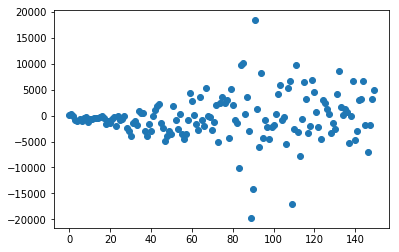

In [91]:
plt.scatter(range(len(res)), res)

In [ ]:
def param_amplitude(file):
    
    st = read(file)
    tr = st[0]
    
    if len(tr.data) < 1:
        return None
    
    tr = tr.detrend() # TODO: Check if necessary
    
    data = tr.data
    
    sps = 50
    start = 0
    end = sps
    
    amplitudes = []
    n_sec = 0
        
    while end <= len(data):
        
        batch = data[start:end]
        amp = max(batch) - min(batch)
        amplitudes.append(amp)
        
        start = end
        end += sps
        n_sec +=1
        
    amps_normed = []
    for amp in amplitudes:
        amps_normed.append( (amp * n_sec) / sum(amplitudes) )
        
    return amps_normed

In [ ]:
amp = param_amplitude(test_file)

In [ ]:
plt.figure(figsize=(6,4), dpi=100)
y_font_size = 20
plt.plot(amp)
#plt.legend(loc = 'right', prop={'size': 11})
plt.ylabel(r'$f_{max}$', fontsize=y_font_size)
plt.xlabel('Time [s]', fontsize=y_font_size)